In [1]:
import requests
import zipfile
import os
from tqdm.auto import tqdm

# --- 1. НАСТРОЙКИ ---


PUBLIC_LINK = "https://disk.yandex.ru/d/kz9g5msVqtahiw"  
ZIP_FILE_NAME = 'nutrition.zip'
DATA_DIR = './data'

# --- 2. ФУНКЦИЯ ДЛЯ ЗАГРУЗКИ ---

def download_file_from_yandex_disk(public_link, destination_path):
    """Загружает файл с Яндекс.Диска по публичной ссылке с progress bar."""
    
    # Получаем прямую ссылку для скачивания через API Яндекса
    api_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_link}"
    
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Проверяем, что запрос прошел успешно
        download_url = response.json()['href']
    except requests.RequestException as e:
        print(f"Ошибка получения ссылки для скачивания: {e}")
        return

    # Начинаем скачивание файла
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            
            with open(destination_path, 'wb') as f, tqdm(
                desc=destination_path,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        print(f"Файл '{destination_path}' успешно загружен.")
        return True
    except requests.RequestException as e:
        print(f"Ошибка при скачивании файла: {e}")
        return False

# --- 3. ОСНОВНОЙ КОД ---

# Проверяем, существует ли уже папка с данными, чтобы не делать лишнюю работу
if os.path.exists(DATA_DIR) and os.path.exists(os.path.join(DATA_DIR, 'dish.csv')):
    print(f"Папка '{DATA_DIR}' уже существует и содержит данные. Пропускаем загрузку и распаковку.")
else:
    # Шаг 1: Загрузка архива
    print("Начинаю загрузку архива с Яндекс.Диска...")
    if download_file_from_yandex_disk(PUBLIC_LINK, ZIP_FILE_NAME):
        
        # Шаг 2: Создание папки для данных, если ее нет
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
            
        # Шаг 3: Распаковка архива
        print(f"\nНачинаю распаковку '{ZIP_FILE_NAME}' в папку '{DATA_DIR}'...")
        try:
            with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
                zip_ref.extractall(DATA_DIR)
            print("Архив успешно распакован.")
            
            # Шаг 4 (опционально): Удаление zip-архива после распаковки для экономии места
            os.remove(ZIP_FILE_NAME)
            print(f"Файл '{ZIP_FILE_NAME}' удален.")
            
        except zipfile.BadZipFile:
            print(f"Ошибка: файл '{ZIP_FILE_NAME}' не является корректным zip-архивом.")
            
    print("\nПодготовка данных завершена!")

Папка './data' уже существует и содержит данные. Пропускаем загрузку и распаковку.


/home/ubuntu/food_calories/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

# Укажите путь к вашей папке 'data'
DATA_DIR = './data'

In [3]:
# --- 1. Загрузка CSV файлов ---
path_dish = os.path.join(DATA_DIR, 'dish.csv')
path_ingredients = os.path.join(DATA_DIR, 'ingredients.csv')

df_dish = pd.read_csv(path_dish)
df_ingredients = pd.read_csv(path_ingredients)

print("--- Таблица с блюдами (dish.csv) ---")
df_dish.info()
print(df_dish.head())

print("\n--- Таблица с ингредиентами (ingredients.csv) ---")
df_ingredients.info()
print(df_ingredients.head())

--- Таблица с блюдами (dish.csv) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2

count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64


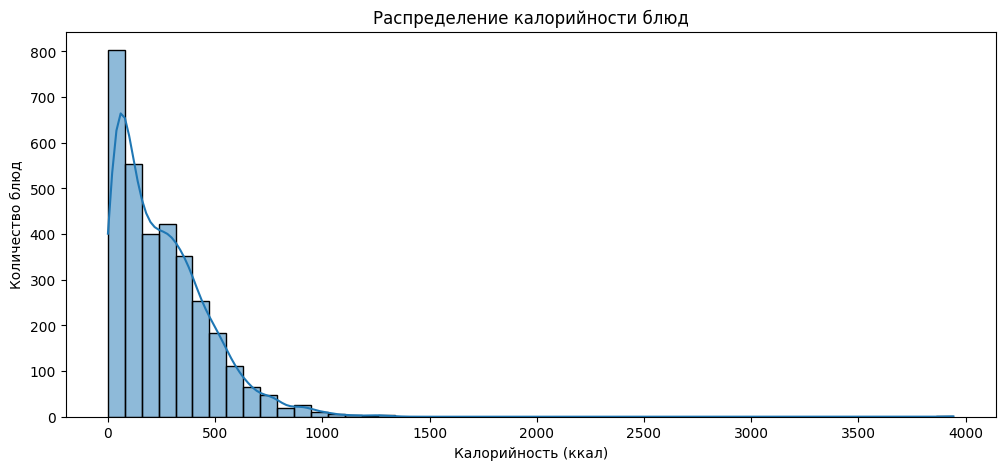

In [4]:
# --- 2. Анализ целевой переменной `total_calories` ---
print(df_dish['total_calories'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(df_dish['total_calories'], bins=50, kde=True)
plt.title('Распределение калорийности блюд')
plt.xlabel('Калорийность (ккал)')
plt.ylabel('Количество блюд')
plt.show()

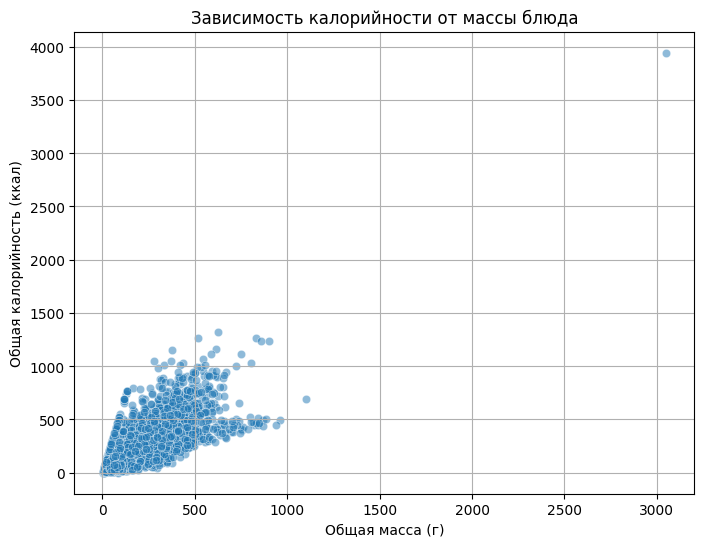

Коэффициент корреляции между массой и калорийностью: 0.76


In [5]:
# --- 3. Анализ связи между массой и калорийностью ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dish, x='total_mass', y='total_calories', alpha=0.5)
plt.title('Зависимость калорийности от массы блюда')
plt.xlabel('Общая масса (г)')
plt.ylabel('Общая калорийность (ккал)')
plt.grid(True)
plt.show()

correlation = df_dish['total_mass'].corr(df_dish['total_calories'])
print(f"Коэффициент корреляции между массой и калорийностью: {correlation:.2f}")



count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: ingredient_count, dtype: float64


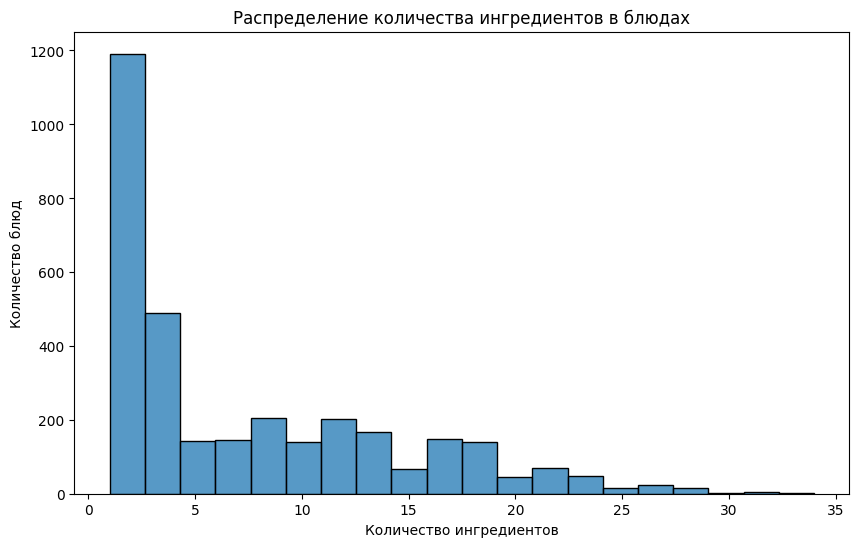

In [6]:
# --- 4. Анализ количества ингредиентов ---
df_dish['ingredient_count'] = df_dish['ingredients'].apply(lambda s: len(s.split(';')))

print(df_dish['ingredient_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_dish['ingredient_count'], bins=20, kde=False)
plt.title('Распределение количества ингредиентов в блюдах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.show()

--- 5 случайных изображений из датасета ---


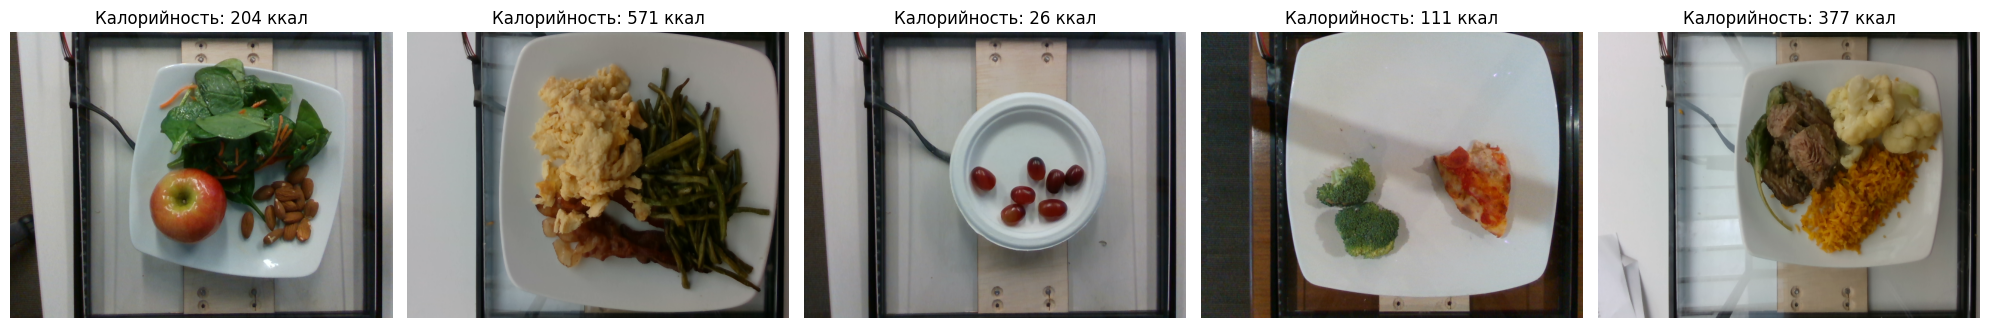

In [7]:
# --- 5. Визуальный анализ изображений ---
print("--- 5 случайных изображений из датасета ---")

images_dir = os.path.join(DATA_DIR, 'images')
all_dish_ids = df_dish['dish_id'].tolist()
random_dish_ids = random.sample(all_dish_ids, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, dish_id in enumerate(random_dish_ids):
    image_path = os.path.join(images_dir, dish_id, 'rgb.png')
    
    try:
        img = Image.open(image_path)
        calories = df_dish[df_dish['dish_id'] == dish_id].iloc[0]['total_calories']
        
        axes[i].imshow(img)
        axes[i].set_title(f"Калорийность: {calories:.0f} ккал")
        axes[i].axis('off')

    except FileNotFoundError:
        axes[i].set_title(f"Изображение\nне найдено")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# --- ЭТАП 3: ОБУЧЕНИЕ МОДЕЛИ ---

import config

from scripts.utils import train_model

print("--- НАСТРОЙКИ ОБУЧЕНИЯ ---")
print(f"Устройство: {config.DEVICE}")
print(f"Количество эпох: {config.EPOCHS}")
print(f"Размер батча: {config.BATCH_SIZE}")
print(f"Путь для сохранения модели: {config.MODEL_SAVE_PATH}")
print("--------------------------\n")


train_model(config)

--- НАСТРОЙКИ ОБУЧЕНИЯ ---
Устройство: cuda
Количество эпох: 20
Размер батча: 32
Путь для сохранения модели: ./best_calorie_predictor_regularized.pth
--------------------------

Обучение будет на устройстве: cuda


/home/ubuntu/food_calories/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/food_calories/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s] 



--- Эпоха 1 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 131.63


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 104.18
✨ Новая лучшая модель сохранена! MAE = 104.18

--- Эпоха 2 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 108.67


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


MAE на тесте: 102.33
✨ Новая лучшая модель сохранена! MAE = 102.33

--- Эпоха 3 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 103.83


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


MAE на тесте: 90.80
✨ Новая лучшая модель сохранена! MAE = 90.80

--- Эпоха 4 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 92.11


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 81.89
✨ Новая лучшая модель сохранена! MAE = 81.89

--- Эпоха 5 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 87.99


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


MAE на тесте: 74.89
✨ Новая лучшая модель сохранена! MAE = 74.89

--- Эпоха 6 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 87.54


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


MAE на тесте: 74.77
✨ Новая лучшая модель сохранена! MAE = 74.77

--- Эпоха 7 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 84.20


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 73.82
✨ Новая лучшая модель сохранена! MAE = 73.82

--- Эпоха 8 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 82.71


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 74.30

--- Эпоха 9 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 82.58


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


MAE на тесте: 72.60
✨ Новая лучшая модель сохранена! MAE = 72.60

--- Эпоха 10 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.76it/s]


Средняя MAE на обучении: 83.69


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 72.78

--- Эпоха 11 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 81.85


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 71.54
✨ Новая лучшая модель сохранена! MAE = 71.54

--- Эпоха 12 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 80.81


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


MAE на тесте: 72.70

--- Эпоха 13 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.78it/s]


Средняя MAE на обучении: 82.12


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


MAE на тесте: 71.31
✨ Новая лучшая модель сохранена! MAE = 71.31

--- Эпоха 14 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 78.91


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


MAE на тесте: 71.55

--- Эпоха 15 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 81.04


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


MAE на тесте: 71.66

--- Эпоха 16 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.78it/s]


Средняя MAE на обучении: 80.31


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


MAE на тесте: 72.96

--- Эпоха 17 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 81.35


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


MAE на тесте: 71.56

--- Эпоха 18 / 20 ---


Обучение: 100%|██████████| 87/87 [00:48<00:00,  1.79it/s]


Средняя MAE на обучении: 82.01


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


MAE на тесте: 71.41

--- Эпоха 19 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 82.53


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


MAE на тесте: 73.17

--- Эпоха 20 / 20 ---


Обучение: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Средняя MAE на обучении: 82.02


Оценка: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]

MAE на тесте: 71.67

Обучение завершено!
Лучший результат MAE на тесте: 71.31
